In [14]:
# PROCESS THE GAIA CATALOG OF STARS in DWARF GALAXIES:
# https://www.aanda.org/articles/aa/full_html/2022/01/aa41528-21/aa41528-21.html
# 
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  MAY 2024 CREATE JUPYTER NOTEBOOK

In [15]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table, join, vstack

from astroquery.gaia import Gaia
from astroquery.vizier import Vizier

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [16]:
# Define the metadata for the data set. #FIX LATER
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia Catalog of Nearby Stars'

metadata['catalog'] = 'The Gaia Catalogue of Nearby Stars (Gaia Collaboration, 2021)'
metadata['catalog_author'] = 'Gaia Collaboration'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202039498'
metadata['catalog_bibcode'] = '2021A&A...649A...6G'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'dGal'
metadata['data_group_desc'] = 'Nearby stars in the Milky Way mapped by Gaia'
metadata['data_group_desc_long'] = 'Have you ever wondered what’s out there in space? Now, thanks to Gaia EDR3, the solar neighbourhood has been mapped with great precision out to 100 pc (326 light years)'
metadata['fileroot'] = 'gcns'

file_functions.generate_license_file(metadata)

In [17]:
#reading in the catalogue
catalog = Vizier(catalog='J/A+A/657/A54', columns=['**'], row_limit=-1).query_constraints()
catalog[0]

recno,Galaxy,GaiaEDR3,RA_ICRS,DE_ICRS,Pmemb,_RA.icrs,_DE.icrs
,,,deg,deg,,deg,deg
int32,str15,int64,float64,float64,float64,float64,float64
1,AntliaII,5419369633646204672,146.775514261911069980,-41.23352175894937233,2.249888770970627e-59,146.775514261911098401,-41.23352175894937233
2,AntliaII,5419375131204392832,146.906114586123237586,-41.17527931166872435,5.762638418730926e-72,146.906114586123266008,-41.17527931166872435
3,AntliaII,5419375513456471168,146.787348116358884909,-41.20346246108170618,1.186667715815127e-10,146.787348116358884909,-41.20346246108170618
4,AntliaII,5419375650902893440,146.811841903187513481,-41.18018303040114603,0,146.811841903187541902,-41.18018303040113892
5,AntliaII,5419375857057564544,146.887510496388301817,-41.16502998085414333,0.0001039622176970977,146.887510496388301817,-41.16502998085414333
6,AntliaII,5419375857059237632,146.884375128020820966,-41.18011943877903747,0,146.884375128020820966,-41.18011943877903036
7,AntliaII,5419375960136155904,146.888577243723744914,-41.14227691098627560,8.182790156124776e-11,146.888577243723773336,-41.14227691098627560
8,AntliaII,5419376131934849152,146.864118296485344217,-41.14741505203811300,6.834111742114398e-07,146.864118296485344217,-41.14741505203811300


In [18]:
data=catalog[0]
Table.to_pandas(data)['Galaxy'].unique()

array(['AntliaII', 'AquariusII', 'BootesI', 'BootesII', 'BootesIII',
       'BootesIV', 'CanesVenaticiI', 'CanesVenaticiII', 'Carina',
       'CarinaII', 'CarinaIII', 'CentaurusI', 'CetusII', 'CetusIII',
       'ColumbaI', 'ComaBerenices', 'CraterI', 'CraterII', 'Delve1',
       'Delve2', 'DESJ0225+0304', 'Draco', 'DracoII', 'EridanusII',
       'EridanusIII', 'Fornax', 'GrusI', 'GrusII', 'Hercules',
       'HorologiumI', 'HorologiumII', 'HydraII', 'HydrusI', 'IndusI',
       'IndusII', 'LeoI', 'LeoII', 'LeoIV', 'LeoV', 'LeoT', 'PegasusIII',
       'Phoenix', 'PhoenixII', 'PictorII', 'PictorI', 'PiscesII',
       'ReticulumII', 'ReticulumIII', 'SagittariusII', 'Sculptor',
       'Segue1', 'Segue2', 'Sextans', 'TriangulumII', 'TucanaII',
       'TucanaIII', 'TucanaIV', 'TucanaV', 'UrsaMajorI', 'UrsaMajorII',
       'UrsaMinor', 'VirgoI', 'Willman1', 'LeoA', 'IC1613', 'NGC6822',
       'Peg-dIrr', 'WLM', 'Sg-dIrr', 'UGC4879', 'NGC3109', 'SextansA',
       'M33', 'SextansB'], dtype=object

In [19]:
catalog

TableList with 1 tables:
	'0:J/A+A/657/A54/pmem' with 8 column(s) and 645720 row(s) 

In [20]:
len(data[data['Pmemb']>0.5])

53320

In [21]:
data.remove_rows(np.where(data['Pmemb']<0.5)[0])

In [22]:
#Query Gaia ESA ADQL server using Gaia EDR3 IDs to obtain proper motion to calculate uvw as well as photometric data

#log in to Gaia Server - Can change to different credentials file for a different user
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#grab username from file
file = open('../common/gaia_credentials.txt', 'r')
username = file.readline().strip()

#Delete tabel from a previous attempt
#Gaia.delete_user_table('d_gal')
#Upload table (table name will be forced to lowercase)
job = Gaia.upload_table(upload_resource=data[['GaiaEDR3']], table_name="d_gal", format="csv")

#Query Gaia DR3 source for parallaxes
#Potentially want Bailer Jones distances pending figuring out the parallax error issue
job = Gaia.launch_job_async("select a.GaiaEDR3, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo, "
                            "c.pmra, c.pmdec, c.radial_velocity, c.phot_g_mean_mag, c.bp_g, c.teff_gspphot "
                            "from user_"+username+".d_gal a inner join external.gaiaedr3_distance bj on a.GaiaEDR3 = bj.source_id "
                            "inner join gaiadr3.gaia_source c on a.GaiaEDR3 = c.source_id",
                            dump_to_file=False)

#put the resulting table into a dataframe and drop the unnecessary index column
data = join(data, job.get_results(), keys='GaiaEDR3', join_type='left')
# data.remove_column('xhip_main_oid')
#Deleting table and job from Gaia ESA server so we don't clog the memory
Gaia.delete_user_table('d_gal')
Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Sending pytable.
Uploaded table 'd_gal'.
INFO: Query finished. [astroquery.utils.tap.core]
Table 'd_gal' deleted.
Removed jobs: '1761243723231O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [23]:
data

recno,Galaxy,GaiaEDR3,RA_ICRS,DE_ICRS,Pmemb,_RA.icrs,_DE.icrs,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_g,teff_gspphot
,,,deg,deg,,deg,deg,pc,pc,pc,pc,pc,pc,mas / yr,mas / yr,km / s,mag,mag,K
int32,str15,int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32
586270,Segue2,87195223452752384,34.814229508135383639,20.05514584511052334,0.8514055398626356,34.814229508135376534,20.05514584511051979,1173.5038,1801.9487,635.55457,1460.0697,4089.0916,707.81586,3.1150425831386492,0.5880428278915883,--,20.656168,0.35815048,--
586289,Segue2,87200377413712384,34.878286017882501824,20.07036080281766033,0.6378775499316831,34.878286017882508929,20.07036080281766033,716.9044,1468.7169,361.76837,5845.947,6785.251,4723.3667,1.6659116282230717,2.5258634906084723,--,20.747362,0.315073,--
586290,Segue2,87200583572213248,34.883528091308086516,20.09618854352710215,0.6398731147832003,34.883528091308093622,20.09618854352710215,2724.1025,6040.3174,1829.2607,4384.1826,5364.3535,3770.474,0.8902226989790806,-1.1261354337510479,--,19.383242,0.5799141,--
586294,Segue2,87201171982969088,34.844632344785786415,20.07869982122890562,0.9870701291424898,34.844632344785786415,20.07869982122890562,3882.5327,7143.307,2431.45,4314.216,5383.5625,3617.1875,1.1788856622940787,-0.37779727431494703,--,18.834503,0.4973774,4541.5156
586296,Segue2,87201648723742592,34.836949720454335022,20.13165911588282597,0.9783842076583982,34.836949720454335022,20.13165911588282597,1040.6174,1981.5366,614.79895,10142.45,12388.1455,8601.18,0.7224026673255213,1.804989889952867,--,20.583813,0.50066566,--
586297,Segue2,87201648724314880,34.838024554660506737,20.12784766639461154,0.9999855967296054,34.838024554660513843,20.12784766639461154,2806.3806,4366.701,1789.7737,2235.8586,2676.366,1662.9287,1.3649950859013835,-0.05442406676168796,--,18.91141,0.10320282,7486.2812
586298,Segue2,87201923602037248,34.903749773319425742,20.14599778553319354,0.6356666428163205,34.903749773319432848,20.14599778553319354,1392.2886,2084.0142,921.571,7457.03,10456.809,6187.531,0.15486757254115213,-0.8576775781443037,--,19.809875,0.2841339,--
586300,Segue2,87202026681250432,34.888056978598541491,20.14172977246510854,0.9999489003579832,34.888056978598541491,20.14172977246510854,5703.155,7401.7314,4705.867,7306.672,8676.343,5515.811,1.5014395199452235,-0.2675470165757461,--,16.16734,0.6877804,5199.9893


In [24]:
#setting dcalc based on r_med_geo (if>500pc and photogeo exists, we choose photogeo and set dcalc to 1, else geo and dcalc to 2)
data['dcalc'] = [1 if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else 2 for i in range(len(data))]

#setting metadata for dcalc
data['dcalc'] = data.Column(data['dcalc'],
                            meta=collections.OrderedDict([('ucd', 'meta.dcalc')]),
                            description='Distance Indicator: 1 indicates a Bailer-Jones photogeometric distance; 2 indicates a Bailer-Jones geometric distance')

#Choosing distance based on dcalc
data['bj_distance'] = [data['r_med_photogeo'][i] if data['dcalc'][i]==1 else data['r_med_geo'][i] for i in range(len(data))]
data['bj_distance'].unit=u.pc

#Choosing and calculating distance error based on the distance we chose
data['e_bj_dist'] = [((data['r_hi_photogeo'][i]-data['r_lo_photogeo'][i])/2)*u.pc if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else ((data['r_hi_geo'][i]-data['r_lo_geo'][i])/2)*u.pc for i in range(len(data))]

In [25]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [26]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='RA_ICRS', dec='DE_ICRS', pmra='pmra', pmde='pmdec', radial_velocity='radial_velocity', frame='icrs')

In [27]:
#calculating absolute magnitudes
#calculate absolute V mag based on apparent magnitude and distance
data['appmag'] = data.MaskedColumn(data=data['phot_g_mean_mag'],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.mag;em.opt.G')]),
                             format='{:.6f}',
                             description='Apparent magnitude in Gaia G-band')
data['absmag'] = data.MaskedColumn(data=[data['appmag'][i]+5-5*np.log10(data['dist_pc'][i]) for i in range(len(data))],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.magAbs;em.opt.G')]),
                             format='{:.6f}',
                             description='Absolute magnitude in Gaia G-band')

In [28]:
#calculate luminosity based on absolute magnitude
data['lum'] = [10**(1.89 - 0.4*data['absmag'][i]) for i in range(len(data))]
small_luminosities = np.where((data['lum']>0.0) & (data['lum']<0.001))[0]
data['lum'][small_luminosities] = [0.001]*len(small_luminosities)

data['lum'] = data.MaskedColumn(data=data['lum'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.luminosity')]),
                             format='{:.6f}',
                             description='Stellar Luminosity')

(array([  2.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   2.,   2.,   1.,   2.,   1.,   2.,   2.,   1.,
          5.,   5.,   4.,   3.,  10.,   3.,   7.,   8.,  11.,  19.,   9.,
         14.,  26.,  26.,  16.,  19.,  26.,  33.,  22.,  41.,  41.,  41.,
         33.,  40.,  48.,  47.,  71.,  66.,  53.,  67.,  55.,  97.,  98.,
         84., 107., 107., 126., 139., 126., 134., 142., 173., 157., 178.,
        189., 203., 214., 235., 257., 246., 235., 282., 324., 334., 323.,
        299., 345., 367., 385., 349., 367., 391., 411., 378., 391., 402.,
        408., 385., 410., 377., 391., 401., 413., 406., 413., 406., 425.,
        424., 448., 445., 462., 431., 461., 530., 542., 548., 543., 565.,
        594., 584., 639., 588., 620., 656., 683., 712., 721., 810., 790.,
        814., 773., 844., 919., 930., 962., 886., 869., 869., 902., 849.,
        826., 834., 742., 752., 752., 713., 701., 694., 639., 611., 558.,
        559., 556., 514., 469., 416., 

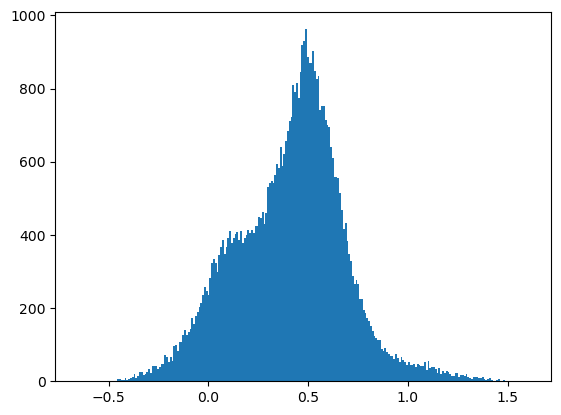

In [29]:
#setting color and visualizing
data['color'] = data.MaskedColumn(data=data['bp_g'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.color')]),
                             format='{:.2f}',
                             description='Gaia BP-G color')
plt.hist(data['color'], bins=250)

<function matplotlib.pyplot.show(close=None, block=None)>

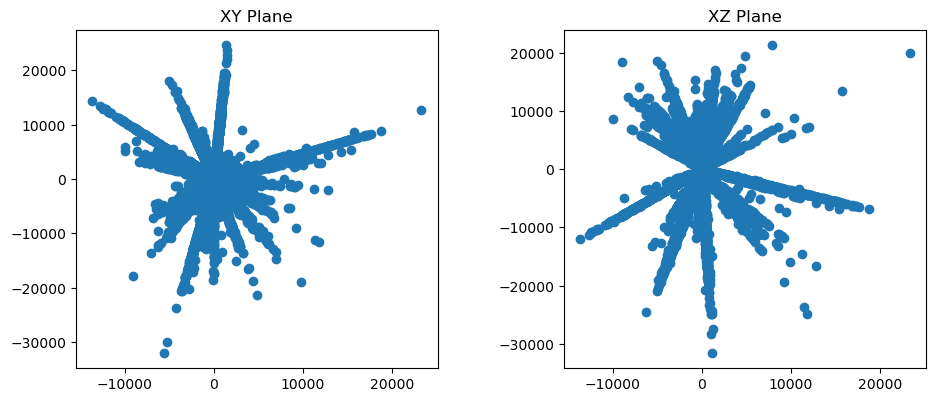

In [30]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

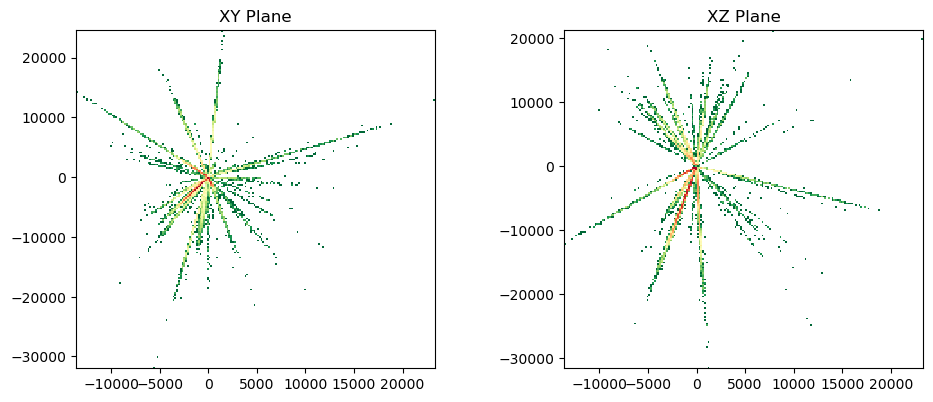

In [31]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [32]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['GaiaEDR3']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia EDR3 Source ID')

#construct a label column
data['label'] = ['GaiaEDR3_'+ str(source) for source in data['GaiaEDR3']]  #leaving for now in case we want to add other labels

In [33]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [34]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float32,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float32,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [35]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [36]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [37]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))